This document is a Python exploration of this R-based document: http://m-clark.github.io/data-processing-and-visualization/.  It is intended for those new to modeling and related concepts.  Code is *not* optimized for anything but learning.  In addition, all the content is located with the main document, not here, so many sections may not be included.  I only focus on reproducing the code chunks.

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Model Criticism

## Model Fit

### Standard Linear Model

#### Statistical Assessment

In [2]:
happy = pd.read_csv('../data/world_hapiness.csv')


In [3]:
happy_model_base = smf.ols(
  'happiness_score ~ democratic_quality + generosity + log_gdp_per_capita',
  data = happy
).fit()

#### Statistical

In a standard linear model we can compare a model where there are no covariates vs. the model we actually care about, which may have many predictor variables.  This is an almost useless test, but the results are typically reported both in standard output and academic presentation.  Let's think about it conceptually- how does the variability in our target break down?

<br>
$$\textrm{Total Variance} = \textrm{Model Explained Variance} + \textrm{Residual Variance}$$

So the variability in our target (TV) can be decomposed into that which we can explain with the predictor variables (MEV), and everything else that is not in our model (RV). If we have nothing in the model, then TV = RV.

Let's revisit the summary of our model.  Note the *F-statistic*.

In [4]:
happy_model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     309.6
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          1.24e-104
Time:                        21:50:36   Log-Likelihood:                -390.15
No. Observations:                 411   AIC:                             788.3
Df Residuals:                     407   BIC:                             804.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0105      0.314     -3.214      0.001      -1.628      -0.393
democratic_quality     0.1704      0.046      3.714      0.000       0.080       0.261
generosity             1.1608      0.195      5.938      0.000       0.777       1.545
log_gdp_per_capita     0.6934      0.033     20.792      0.000       0.628       0.759
==============================================================================
Omnibus:                        3.428   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.731
Skew:                           0.075   Prob(JB):                        0.255
Kurtosis:                       2.630   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard F statistic can be calculated as follows, where $p$ is the number of predictors:

$$F = \frac{MV/p}{RV/(N-p-1)}$$

Conceptually it is a ratio of average squared variance to average unexplained variance. We can see this more explicitly as follows, where each predictor's contribution to the total variance is provided in the `sum_sq` column. 

In [5]:
sm.stats.anova_lm(happy_model_base) 

,df,sum_sq,mean_sq,F,PR(>F)
democratic_quality,1.0,189.191976,189.191976,479.300218,8.896592e-71
generosity,1.0,6.774203,6.774203,17.161811,4.176867e-05
log_gdp_per_capita,1.0,170.649392,170.649392,432.324313,5.925015e-66
Residual,407.0,160.653242,0.394725,NaN,NaN


If we add those together and use our formula above we get:

$$F = \frac{366.62/3}{160.653/407} = 309.6$$

Which is what is reported in the summary of the model. And these values can be extracted from the summary object.

In [6]:
happy_model_base.fvalue
happy_model_base.f_pvalue

1.241861773180128e-104

Because the F-value is so large and p-value so small, we can demonstrate this more clearly with a worse model.

In [7]:
f_test = smf.ols('happiness_score ~ generosity', data = happy)

In [8]:
f_test.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.780
Date:                Tue, 25 Feb 2020   Prob (F-statistic):            0.00318
Time:                        21:50:36   Log-Likelihood:                -819.50
No. Observations:                 535   AIC:                             1643.
Df Residuals:                     533   BIC:                             1652.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4190      0.049    111.692      0.000       5.324       5.514
generosity     0.8994      0.304      2.963      0.003       0.303       1.496
==============================================================================
Omnibus:                       77.072   Durbin-Watson:                   0.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.350
Skew:                          -0.018   Prob(JB):                     6.28e-05
Kurtosis:                       2.069   Cond. No.                         6.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
from scipy.stats import f

1 - f.cdf(8.780433, 1, 533)

0.0031808086892723964

#### R-squared

The statistical result just shown is mostly a straw man type of test- who actually cares if our model does statistically better than a model with nothing in it?  Surely if you don't do better than nothing, then you may need to think more intently about what you are trying to model and how.  But just because you can knock the straw man down, it isn't something to get overly excited about. Let's turn instead to a different concept- the amount of variance of the target variable that is explained by our predictors.  For the standard linear model setting, this statistic is called *R-squared* ($R^2$).

Going back to our previous notions, $R^2$ is just:

$$R^2 =\textrm{Model Explained Variance}/\textrm{Total Variance}$$

This too is reported by default in our summary printout, or extract it from the model itself.

In [10]:
happy_model_base.rsquared

0.695310554483092

With our values from before for model and total variance, we can calculate it ourselves.

In [11]:
366.62 / 527.27

0.6953173895727047

Here is another way.  Let's get the model predictions, and see how well they correlate with the target.

In [12]:
predictions = happy_model_base.fittedvalues
target = happy_model_base.model.endog  # 
rho = np.corrcoef(predictions, target)
print(rho[0,1])
print(rho[0,1]**2)

0.8338528374258207
0.6953105544830922


One problem with $R^2$ is that it always goes up, no matter what nonsense you add to a model.  This is why we have an *adjusted $R^2$* that attempts to balance the sample size and model complexity. 

In [13]:
happy_model_base.rsquared_adj

0.6930646863343187

### Classification

For categorical targets we must think about obtaining predictions that allow us to classify the observations into specific categories.  Not surprisingly, this will require different metrics to assess model performance.

#### Accuracy and other metrics

A very natural starting point is *accuracy*, or what percentage of our predicted class labels match the observed class labels.  However, our model will not spit out a character string, only a number. On the scale of the linear predictor it can be anything, but we will at some point transform it to the probability scale, obtaining a predicted probability for each category.  The class associated with the highest probability is the predicted class.  In the case of binary targets, this is just an <span class="func" style = "">if_else</span> statement for one class `'class A' if (probability >= .5) else 'class B'`.

With those predicted labels and the observed labels we create what is commonly called a *confusion matrix*, but would more sanely be called a *classification table*, *prediction table*, or just about any other name one could come up with in the first 10 seconds of trying.  Let's look at the following hypothetical result.

In [14]:
pd.DataFrame({'Observed 1': [41, 16], 
              'Observed 0': [21, 13]}, 
             index = ['Predicted 1', 'Predicted 0'])

,Observed 1,Observed 0
Predicted 1,41,21
Predicted 0,16,13


In [15]:
pd.DataFrame({'Observed 1': ['A', 'C'], 
              'Observed 0': ['B', 'D']}, 
             index = ['Predicted 1', 'Predicted 0'])

,Observed 1,Observed 0
Predicted 1,A,B
Predicted 0,C,D


In some cases we predict correctly, in other cases not.  In this 2 x 2 setting we label the cells A through D.  With things in place, consider the following the following nomenclature.

*True Positive*, *False Positive*, *True Negative*, *False Negative*: Above, these are A, B, D, and C respectively.

Now let's see what we can calculate.

*Accuracy*: Number of correct classifications out of all predictions (A + D)/Total. In the above example this would be (41 + 13)/91.

*Error Rate*: 1 - Accuracy.

*Sensitivity*: is the proportion of correctly predicted positives to all true positive events: A/(A + C).  In the above example this would be 41/57. High sensitivity would suggest a low type II error rate (see below), or high statistical power. Also known as *true positive rate*.

*Specificity*: is the proportion of correctly predicted negatives to all true negative events: D/(B + D).  In the above example this would be 13/34. High specificity would suggest a low type I error rate (see below). Also known as *true negative rate*.

*Positive Predictive Value* (PPV): proportion of true positives of those that are predicted positives: A/(A + B). In the above example this would be 41/62.

*Negative Predictive Value* (NPV): proportion of true negatives of those that are predicted negative: D/(C + D). In the above example this would be 13/29.

*Precision*:  See PPV.

*Recall*: See sensitivity.

*Lift*: Ratio of positive predictions given actual positives to the proportion of positive predictions out of the total: (A/(A + C)) / ((A + B)/Total). In the above example this would be (41/(41 + 16))/((41 + 21)/(91)).

*F Score* (F1 score): Harmonic mean of precision and recall: 2\*(Precision\*Recall)/(Precision+Recall). In the above example this would be 2\*(.66\*.72)/(.66+.72).

*Type I Error Rate* (false positive rate): proportion of true negatives that are incorrectly predicted positive: B/(B+D). In the above example this would be 21/34.  Also known as *alpha*.

*Type II Error Rate* (false negative rate): proportion of true positives that are incorrectly predicted negative: C/(C+A). In the above example this would be 16/57. Also known as *beta*.

There are many others. See the [pycm module](https://github.com/sepandhaghighi/pycm) for example.

## Model Assumptions

There are quite a few assumptions for the standard linear model that we could talk about, but I'll focus on just a handful, ordered roughly in terms of the severity of violation. 

- Correct model
- Heteroscedasticity
- Independence of observations
- Normality

We actually showed some of this before.

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(happy_model_base, 'generosity', fig = fig)
plt.show()

<Figure size 800x600 with 4 Axes>

We can also inspect a histogram of the residuals to check for normality.  Here I use seaborn as a nice way to get the density overlay of the histogram.

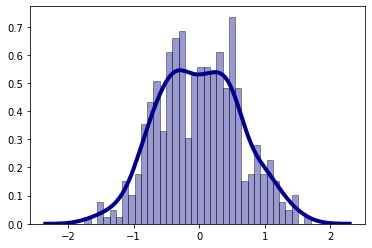

In [17]:
import seaborn as sns

sns.distplot(
    happy_model_base.resid, 
    hist = True, 
    kde = True,
    bins = int(180/5), 
    color = 'darkblue', 
    hist_kws = {'edgecolor':'black'},
    kde_kws={'linewidth': 4}
)

You can find more demos [here](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html).

## Predictive Performance

In [18]:
from sklearn.model_selection import train_test_split

X, y =  happy_model_base.model.exog, happy_model_base.model.endog

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.33, 
    random_state = 1212
)
X_train

happy_model_train = sm.OLS(y_train, X_train).fit()

predictions = happy_model_train.predict(exog = X_test)

Comparing our loss on training and test (i.e. RMSE), we can see the loss is greater on the test set.  

In [19]:
# 'by-hand' calculations
RMSE_train = np.sqrt(happy_model_train.resid.dot(happy_model_train.resid)/happy_model_train.nobs)
RMSE_test = np.sqrt(sum((predictions - y_test)**2)/y_test.shape[0])

pd.DataFrame({'RMSE_train': RMSE_train, 'RMSE_test': RMSE_test}, index = [0])

,RMSE_train,RMSE_test
0,0.631502,0.615318


In [20]:
# # alternative
from sklearn.metrics import mean_squared_error


pd.DataFrame({
    'RMSE_train': np.sqrt(mean_squared_error(happy_model_train.fittedvalues, y_train)),
    'RMSE_test': np.sqrt(mean_squared_error(predictions, y_test))}, 
    index = [0])



,RMSE_train,RMSE_test
0,0.631502,0.615318


## Model Comparison

### Example: Additional covariates

A starting point for adding model complexity is simply adding more covariates.  Let's add life expectancy and a yearly trend to our happiness model.  To make this model comparable to our baseline model, they need to be fit to the same data, and life expectancy has a couple missing values the others do not.  So we'll start with some data processing. I will start by standardizing some of the variables, and making year start at zero, which will represent 2008, and finally dropping missing values.  Refer to our previous section on transforming variables if you want to.




In [21]:
def scale(x):
    return((x - np.nanmean(x, axis=0))/np.nanstd(x, axis=0))

happy_processed = happy[[
    'country', 
    'year', 
    'happiness_score',
    'democratic_quality',
    'generosity',
    'healthy_life_expectancy_at_birth',
    'log_gdp_per_capita'
]].apply(
    lambda x: scale(x)
    if x.name in [
        'happiness_score',
        'democratic_quality',
        'generosity',
        'healthy_life_expectancy_at_birth',] 
    else x
).assign(
    year = happy.year - np.min(happy.year)
).dropna()

happy_processed.head()

,country,year,happiness_score,democratic_quality,generosity,healthy_life_expectancy_at_birth,log_gdp_per_capita
7,Afghanistan,10,-1.625550,-1.950587,0.545034,-1.307413,7.500539
8,Afghanistan,11,-1.815967,-1.963219,0.314034,-1.333794,7.497038
9,Afghanistan,12,-1.431590,-1.998775,-0.687488,-1.360174,7.497755
18,Albania,10,-0.399795,0.442664,-0.517345,0.618363,9.302960
19,Albania,11,-0.669036,0.449130,-0.127154,0.657933,9.337532


Now let's start with our baseline model again.

In [22]:
happy_model_base = smf.ols(
  'happiness_score ~ democratic_quality + generosity + log_gdp_per_capita',
  data = happy_processed
).fit()

happy_model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     307.8
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          4.51e-104
Time:                        21:50:37   Log-Likelihood:                -339.33
No. Observations:                 409   AIC:                             686.7
Df Residuals:                     405   BIC:                             702.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.7037      0.276    -20.701      0.000      -6.245      -5.162
democratic_quality     0.1348      0.036      3.760      0.000       0.064       0.205
generosity             0.1689      0.028      5.955      0.000       0.113       0.225
log_gdp_per_capita     0.6136      0.030     20.729      0.000       0.555       0.672
==============================================================================
Omnibus:                        3.562   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.837
Skew:                           0.082   Prob(JB):                        0.242
Kurtosis:                       2.626   Cond. No.                         95.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that moving one standard deviation on democratic quality and generosity leads to similar standard deviation increases in happiness.  Moving 10 percentage points in GDP would lead to less than .1 standard deviation increase in happiness.

Now we add our life expectancy and yearly trend.

In [23]:
happy_model_more = smf.ols(
  'happiness_score ~ democratic_quality + generosity + log_gdp_per_capita + healthy_life_expectancy_at_birth + year',
  data = happy_processed
).fit()

happy_model_more.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     214.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.19e-111
Time:                        21:50:37   Log-Likelihood:                -316.73
No. Observations:                 409   AIC:                             645.5
Df Residuals:                     403   BIC:                             669.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.5944      0.532     -6.762      0.000      -4.639      -2.549
democratic_quality                   0.0668      0.035      1.887      0.060      -0.003       0.136
generosity                           0.1648      0.027      6.109      0.000       0.112       0.218
log_gdp_per_capita                   0.3945      0.043      9.277      0.000       0.311       0.478
healthy_life_expectancy_at_birth     0.3871      0.056      6.860      0.000       0.276       0.498
year                                -0.0113      0.032     -0.352      0.725      -0.074       0.052
==============================================================================
Omnibus:                        7.277   Durbin-Watson:                   0.834
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                4.407
Skew:                           0.009   Prob(JB):                        0.110
Kurtosis:                       2.492   Cond. No.                         296.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here it would seem that life expectancy has a notable effect on happiness (shocker), but the yearly trend, while negative, is not statistically notable.  In addition, the democratic effect is no longer significant, as it would seem that it's contribution was more due to it's correlation with life expectancy. But the key question is- is this model better?  

The adjusted $R^2$ seems to indicate that we are doing slightly better with this model, but not by much.

The ANOVA, or analysis of variance test, is essentially comparing whether the residual sum of squares (i.e. the loss) is statistically less for one model vs. the other. In many settings it is often called a *likelihood ratio test*.

In [24]:
# chi.square statistic, p-value, df
happy_model_more.compare_lm_test(happy_model_base)

(42.782243464403486, 5.128069116266907e-10, 2.0)

 An approach that works in many settings is to compare *AIC* (Akaike Information Criterion). AIC is a value based on the likelihood for a given model, but which adds a penalty for complexity, since otherwise any more complex model would result in a larger likelihood (or in this case, smaller negative likelihood).  In the following, $\mathcal{L}$ is the likelihood, and $\mathcal{P}$ is the number of parameters estimated for the model.

$$AIC = -2 ( \ln (\mathcal{L})) + 2 \mathcal{P}$$

In [25]:
[happy_model_base.aic, happy_model_more.aic]

[686.6589001213847, 645.4697022542996]

Again, our new model works better.

### Example: Interactions

Let's now add interactions to our model.  Interactions allow the relationship of a predictor variable and target to vary depending on the values of another covariate.  To keep things simple, we'll add a single interaction to start- I will interact democratic quality with life expectancy.

In [26]:
happy_model_interact = smf.ols(
  'happiness_score ~ democratic_quality + generosity + log_gdp_per_capita + healthy_life_expectancy_at_birth + democratic_quality:healthy_life_expectancy_at_birth',
  data = happy_processed
).fit()

happy_model_interact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     224.5
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          4.32e-114
Time:                        21:50:37   Log-Likelihood:                -310.01
No. Observations:                 409   AIC:                             632.0
Df Residuals:                     403   BIC:                             656.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -3.6670      0.384     -9.555      0.000      -4.421      -2.913
democratic_quality                                      0.0277      0.036      0.761      0.447      -0.044       0.099
generosity                                              0.1417      0.027      5.199      0.000       0.088       0.195
log_gdp_per_capita                                      0.3812      0.042      9.081      0.000       0.299       0.464
healthy_life_expectancy_at_birth                        0.4170      0.056      7.435      0.000       0.307       0.527
democratic_quality:healthy_life_expectancy_at_birth     0.1184      0.032      3.687      0.000       0.055       0.182
==============================================================================
Omnibus:                        3.513   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.780
Skew:                           0.075   Prob(JB):                        0.249
Kurtosis:                       2.625   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient interpretation for variables in the interaction model changes.  For those involved in an interaction, the base coefficient now only describes the effect when the variable they interact with is zero (or is at the reference group if it's categorical). So democratic quality has a slight positive but not statistically notable effect at the mean of life expectancy.

However, this effect increases when life expectancy increases by 1 (i.e. 1 standard deviation) by the value of the interaction coefficient.  The same interpretation goes for life expectancy.  It's base coefficient is when democratic quality is at it's mean, and the interaction term is interpreted identically.

It would be best to visualize the interaction, but the [statsmodels demo](https://www.statsmodels.org/dev/examples/notebooks/generated/categorical_interaction_plot.html) for doing so just uses some random data rather than the model object, which implies you're on your own there, and don't need to use the `interaction_plot` function at all.  One approach would be to use the predict method with `exog` equal to the interaction variables at your chosen values.

### Example: Additive Models

*Generalized additive models* allow our predictors to have a *wiggly* relationship with the target variable.  For more information, see [this document](https://m-clark.github.io/generalized-additive-models/), but for our purposes, that's all you really need to know. We will use the pygam for our demo here.  In this case, we'll allow all the covariates to have a nonlinear relationship, and we denote this with the `s()` syntax.  I show this example for continuity, but this model seems notably different from a statsmodels object, and its AIC doesn't seem comparable, even as its other statistics and plots seem comparable to the R package mgcv.

In [27]:
from pygam import LinearGAM, s

X = np.asmatrix(happy_processed[['democratic_quality', 'generosity', 'log_gdp_per_capita', 'healthy_life_expectancy_at_birth']])
y = np.asmatrix(happy_processed['happiness_score']).flatten()

In [28]:
happy_model_gam = LinearGAM(s(0) + s(1) + s(2) + s(3)).fit(X, y)
happy_model_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      43.002
Link Function:                     IdentityLink Log Likelihood:                                  -708.7661
Number of Samples:                          409 AIC:                                             1505.5362
                                                AICc:                                            1516.4164
                                                GCV:                                                0.2153
                                                Scale:                                               0.175
                                                Pseudo R-Squared:                                   0.8449
Feature Function                  Lam

/Users/micl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


The first thing you may notice is that there are no regression coefficients. This is because the effect of any of these predictors depends on their value, so trying to assess it by a single value would be problematic at best. You can guess what will help us interpret this...

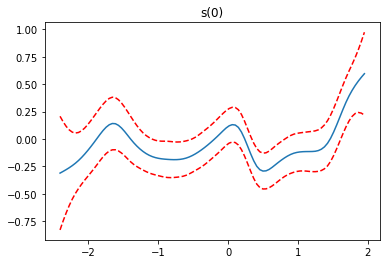

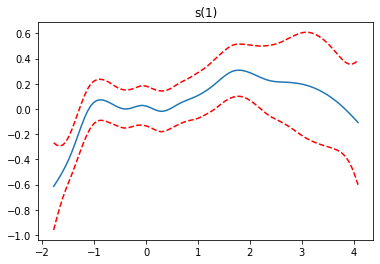

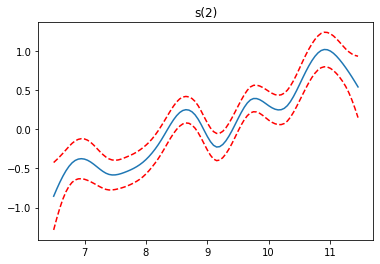

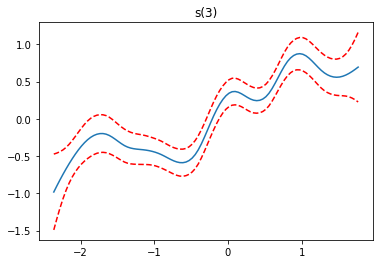

In [29]:
# this code comes from the documentation for pygam
for i, term in enumerate(happy_model_gam.terms):
    if term.isintercept:
        continue

    XX = happy_model_gam.generate_X_grid(term=i)
    pdep, confi = happy_model_gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

Here is a brief summary of interpretation.  We generally don't have to worry about small wiggles.

- `democratic_quality`: Effect is most notable (positive and strong) for higher values. Negligible otherwise.
- `generosity`: Effect seems seems strongly positive, but mostly for lower values of generosity.
- `life_expectancy`: Effect is positive, but only if the country is around the mean or higher.
- `log GDP per capita`: Effect is mostly positive, but may depend on other factors not included in the model.

In terms of general model fit, the `scale` is the same as the residual standard error (squared) in the other models, and is a notably lower than even the model with the interaction. We can also see that the adjusted/Pseudo $R^2$ is higher as well.

Let's check our AIC now to see which model wins. 

In [30]:
# pygam evidently does not calculate AIC in the same way 
model_list = [happy_model_base, happy_model_more, happy_model_interact]

[x.aic for x in model_list] 

[686.6589001213847, 645.4697022542996, 632.029910650047]

In the above, we can see the interaction model wins, but I can assure you the GAM is best, despite the ability

## Model Criticism Summary

Statistical significance with a single model does not provide enough of a story to tell with your data. A better assessment of performance  can be made on data the model has not seen, and can provide a better idea of the practical capabilities of it.  Furthermore, pitting various models of differing complexities will allow for better confidence in the model or set of models we ultimately deem worthy. In general, in more explanatory settings we strive to balance performance with complexity through various means.